In [1]:
## import librerie

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

## creazione df

df1= pd.read_csv("data/gps-26-12-2024.csv",
    usecols=[0, 1, 2, 3, 4, 5, 6 ,7], ## colonne con significato noto
    names=["unixtime", "latitudine", "longitudine", "altitudine", "boh1", "boh2", "precisione_orizzontale", "precisione_verticale"] ## 
    )

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False]




In [2]:
## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = gdf['unixtime'].diff()
    
    return gdf

def aggiungi_delta_distanza(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift())  # shift: prende punto successivo

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['altitudine'].diff())**2
    )

    gdf['distanza_reale'] = gdf['distanza_reale'].fillna(0)
    gdf['distanza_orizzontale'] = gdf['distanza_orizzontale'].fillna(0)


    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= gdf['distanza_reale'] / gdf['delta_tempo']
    gdf['velocita'] = gdf['velocita'].fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff()
    gdf['delta_velocita'] = gdf['delta_velocita'].fillna(0)

    gdf['accelerazione'] = gdf['delta_velocita'] / gdf['delta_tempo']
    gdf['delta_velocita'] = gdf['delta_velocita'].fillna(0)
    
    return gdf

def aggiungi_pendenza(gdf):
    gdf['delta_altitudine'] = gdf['altitudine'].diff()

    gdf['pendenza'] = np.degrees(np.arctan(gdf['delta_altitudine'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf


def aggiungi_accelerazione_max(gdf):
    # Converti la pendenza da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    # Calcola l'accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf


def filtra_punti_temporalmente(gdf, min_tempo=2):

    # Lista per le righe da mantenere
    valid_rows = [0]  # Mantieni sempre il primo punto

    # Itera attraverso i punti
    for i in range(1, len(gdf)):
        # Calcola il tempo tra il punto corrente e l'ultimo punto valido
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']
        
        # Se la differenza di tempo è sufficiente, aggiungi il punto alla lista
        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    
    # Filtra il DataFrame
    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

def filtro_precisione(gdf, precisione_orizzontale, precisione_verticale):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

def filtro_accelerazione(gdf, min_acc, max_acc):

    # Filtra i punti con accelerazioni valide
    gdf_filtrato = gdf[(gdf['accelerazione'] >= min_acc) & (gdf['accelerazione'] <= max_acc)].reset_index(drop=True)
    
    # Ricalcola tutte le statistiche dopo il filtraggio
    gdf_filtrato = aggiungi_delta_tempo(gdf_filtrato)
    gdf_filtrato = aggiungi_delta_distanza(gdf_filtrato)
    gdf_filtrato = aggiungi_velocita(gdf_filtrato)
    gdf_filtrato = aggiungi_accelerazione(gdf_filtrato)
    gdf_filtrato = aggiungi_pendenza(gdf_filtrato)
    gdf_filtrato = aggiungi_accelerazione_max(gdf_filtrato)
    
    return gdf_filtrato




In [3]:
gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")

time_start = df1['unixtime'][0]

In [4]:

def geo_DBSCAN(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp
    gdf['norm_lat'] = gdf.geometry.y  # Latitudine
    gdf['norm_long'] = gdf.geometry.x  # Longitudine
    gdf['norm_alt'] = gdf['altitudine']  # Altitudine

    # Prepara le feature per la normalizzazione
    features = gdf[['norm_lat', 'norm_long', 'norm_alt']].to_numpy()

    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)

    # Applica DBSCAN sui dati normalizzati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster', 'norm_lat', 'norm_long', 'norm_alt']).reset_index(drop=True)



    return gdf_filtrato


In [5]:

def alt_DBSCAN(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp

    gdf['norm_unixtime'] = gdf['unixtime']  # Longitudine
    gdf['norm_alt'] = gdf['altitudine']  # Altitudine

    # Prepara le feature per la normalizzazione
    features = gdf[['norm_unixtime', 'norm_alt']].to_numpy()

    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)

    # Applica DBSCAN sui dati normalizzati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster', 'norm_unixtime', 'norm_alt']).reset_index(drop=True)



    return gdf_filtrato


In [6]:

def distanza_reale_DBSCAN(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp

    gdf['norm_unixtime'] = gdf['unixtime']  # Longitudine
    gdf['norm_distanza_reale'] = gdf['distanza_reale']  # Altitudine

    # Prepara le feature per la normalizzazione
    features = gdf[['norm_unixtime', 'norm_distanza_reale']].to_numpy()

    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)

    # Applica DBSCAN sui dati normalizzati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster', 'norm_unixtime', 'norm_distanza_reale']).reset_index(drop=True)



    return gdf_filtrato


In [7]:
def velocita_DBSCAN(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp

    gdf['norm_unixtime'] = gdf['unixtime']  # Longitudine
    gdf['norm_velocita'] = gdf['velocita']  # Altitudine

    # Prepara le feature per la normalizzazione
    features = gdf[['norm_unixtime', 'norm_velocita']].to_numpy()

    # Normalizzazione Min-Max
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)

    # Applica DBSCAN sui dati normalizzati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normalized_features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster', 'norm_unixtime', 'norm_velocita']).reset_index(drop=True)



    return gdf_filtrato

In [8]:
def alt_DBSCAN1(gdf, eps, min_samples):
    # Estrai latitudine, longitudine, altitudine e timestamp
    gdf['norm_alt'] = gdf['altitudine']  # Altitudine

    # Prepara le feature (senza normalizzare 'unixtime')
    features = gdf[['unixtime', 'norm_alt']].to_numpy()

    # Normalizza solo l'altitudine
    scaler = MinMaxScaler()
    features[:, 1] = scaler.fit_transform(features[:, 1].reshape(-1, 1)).flatten()

    # Applica DBSCAN sui dati
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(features)

    # DBSCAN assegna -1 ai punti considerati rumore
    gdf['cluster'] = db.labels_

    # Mantieni solo i dati che non sono rumore (cluster != -1)
    gdf_filtrato = gdf[gdf['cluster'] != -1].drop(columns=['cluster', 'norm_alt']).reset_index(drop=True)

    return gdf_filtrato


In [9]:
## creazione dati derivati

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)

In [10]:
gdf1 = filtra_punti_temporalmente(gdf1, min_tempo=0.5)

gdf1 = filtro_precisione(gdf1, precisione_orizzontale=12, precisione_verticale= 12)

#gdf1 = filtro_accelerazione(gdf1, min_acc=-8, max_acc=4)


In [11]:
################################
################################
################################
# Esempio di utilizzo con un DataFrame (gdf1)

gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 8400) & (gdf1['unixtime'] - time_start<= 8500)].reset_index(drop=True)

#gdf1=geo_DBSCAN(gdf1, eps=0.5, min_samples=10)
#gdf1=distanza_reale_DBSCAN(gdf1, eps=0.5, min_samples=7)
#gdf1=velocita_DBSCAN(gdf1, eps=0.1, min_samples=10)
#gdf1=alt_DBSCAN1(gdf1, eps=34, min_samples=5)

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)

gdf1.to_csv('data/gdf1.csv', index=False)

gdf1[['longitudine', 'latitudine', 'altitudine', 'distanza_reale', 'velocita', 'delta_tempo', 'precisione_orizzontale','precisione_verticale']].describe()

,longitudine,latitudine,altitudine,distanza_reale,velocita,delta_tempo,precisione_orizzontale,precisione_verticale
count,68.000000,68.000000,68.000000,68.000000,68.000000,67.000000,68.000000,68.000000
mean,12.917826,46.516487,976.657902,27.226860,19.297696,1.477612,6.244118,5.819118
std,0.001761,0.002566,77.003095,26.226093,5.664816,1.340805,1.460053,1.418245
min,12.915014,46.512894,853.096548,0.000000,0.000000,0.991000,4.500000,3.900000
25%,12.916246,46.514197,888.859420,18.579842,15.707500,0.999000,4.975000,4.575000
50%,12.918111,46.515649,995.099131,21.876122,19.002311,1.001000,6.000000,5.950000
75%,12.919275,46.519329,1044.322725,26.453912,22.906868,1.010500,7.000000,7.000000
max,12.920832,46.520540,1089.943094,184.244552,34.779635,7.994000,9.300000,8.400000


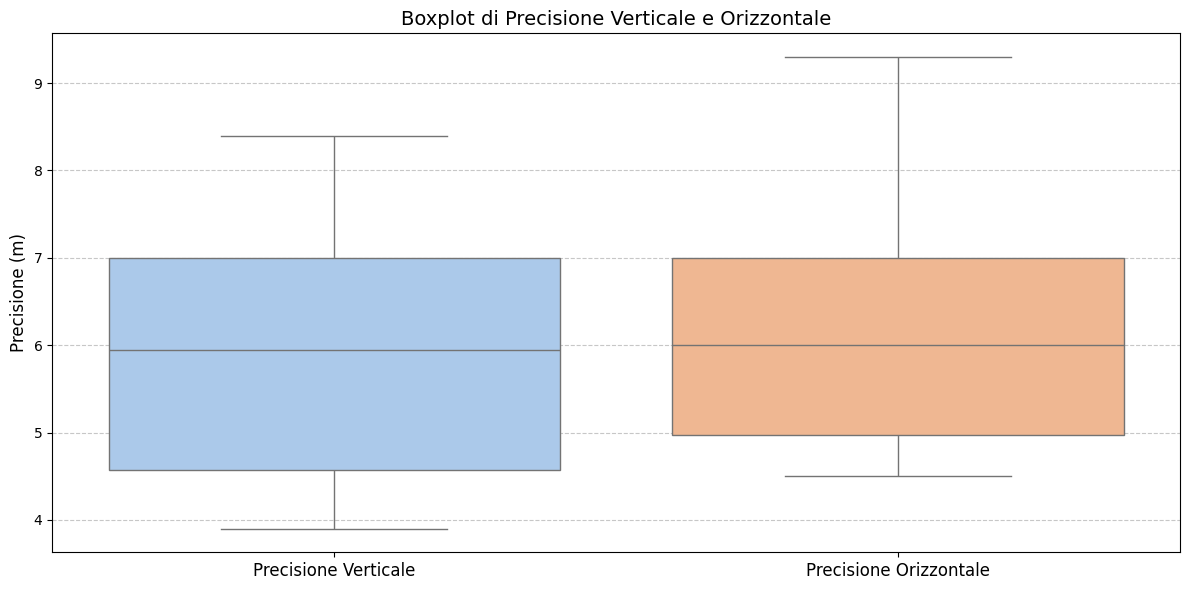

In [12]:
plt.figure(figsize=(12, 6))

# Crea i boxplot affiancati
sns.boxplot(data=gdf1[['precisione_verticale', 'precisione_orizzontale']], palette='pastel')

# Aggiungi titolo e etichette
plt.title('Boxplot di Precisione Verticale e Orizzontale', fontsize=14)
plt.ylabel('Precisione (m)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Precisione Verticale', 'Precisione Orizzontale'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.tight_layout()
plt.show()


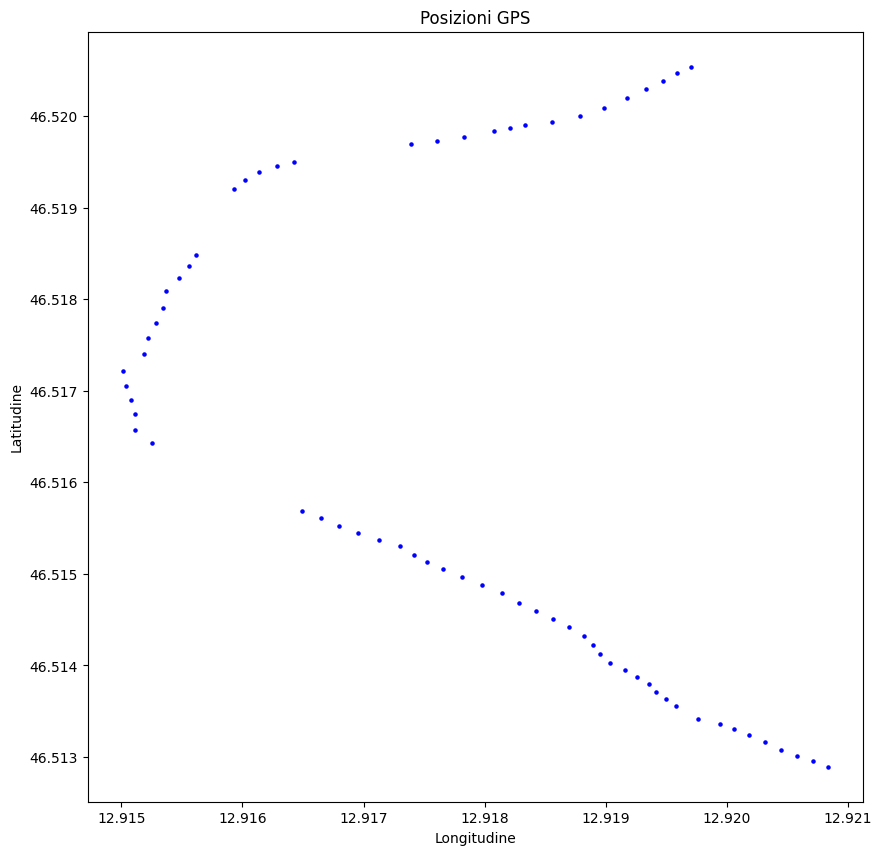

In [13]:


# Esempio di dati (usa i tuoi dati)
latitudini = gdf1['latitudine']
longitudini = gdf1['longitudine']

# Crea il grafico con uno sfondo bianco
plt.figure(figsize=(10, 10))
plt.scatter(longitudini, latitudini, color='blue', marker='o', s=5)  # s è la dimensione dei punti
plt.title("Posizioni GPS")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
#plt.ylim(46.520, 46.525)

# Impostazioni per lo sfondo bianco
plt.gca().set_facecolor('white')

plt.show()


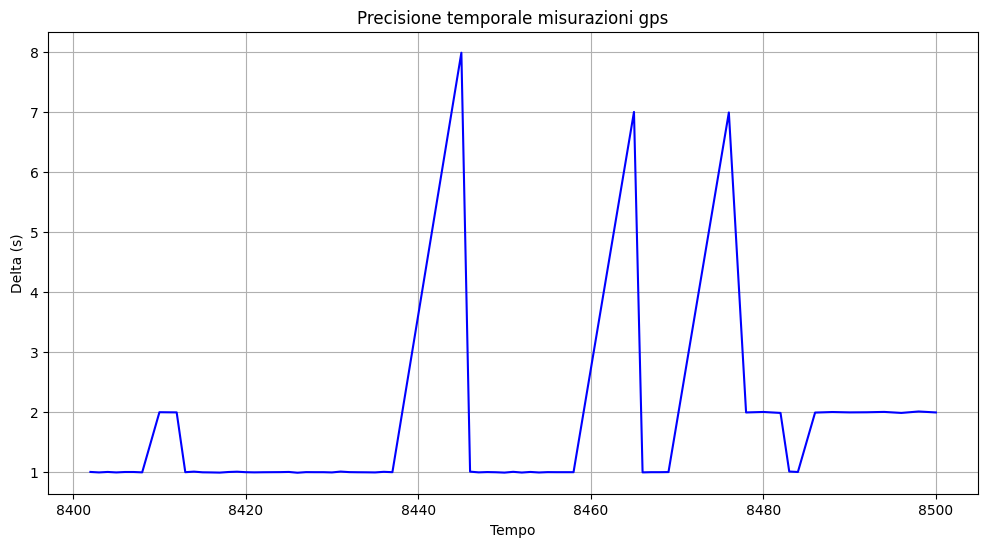

count    67.000000
mean      1.477612
std       1.340805
min       0.991000
25%       0.999000
50%       1.001000
75%       1.010500
max       7.994000
Name: delta_tempo, dtype: float64

In [14]:
## Delta tempo


plt.figure(figsize=(12, 6))
plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['delta_tempo'], 
    label='Intervallo di tempo tra misurazioni', 
    color='blue'
    )

plt.xlabel('Tempo')
plt.ylabel('Delta (s)')
plt.title('Precisione temporale misurazioni gps')
plt.grid(True)
#plt.ylim(0, 600)  ## max 600 secondi-> 10 minuti di pausa
#plt.xlim(12000, 16500)

plt.show()

gdf1["delta_tempo"].describe()


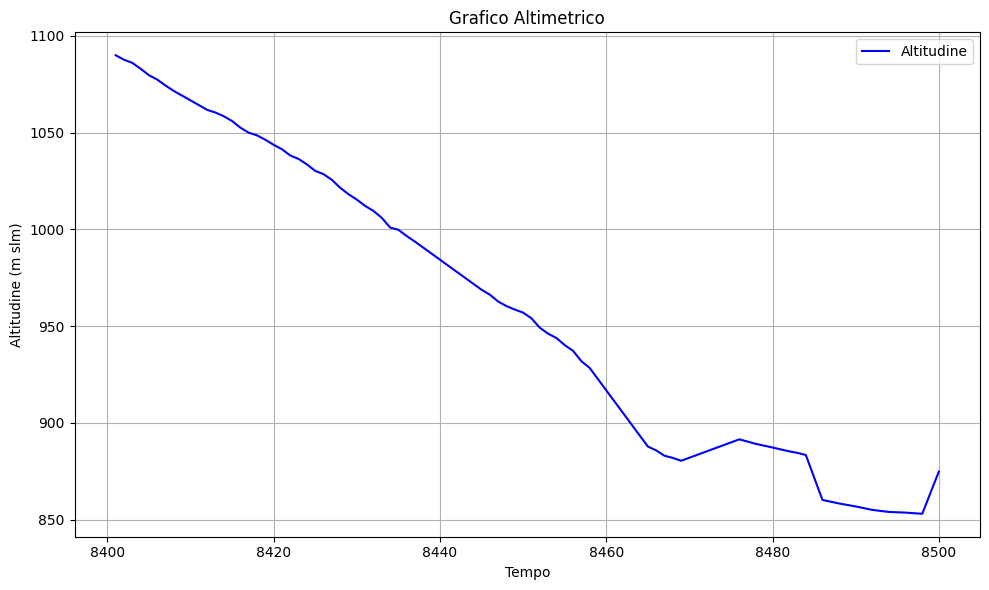

In [15]:
## Altimetria della giornata


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')
plt.title('Grafico Altimetrico')
plt.grid(True)
plt.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()


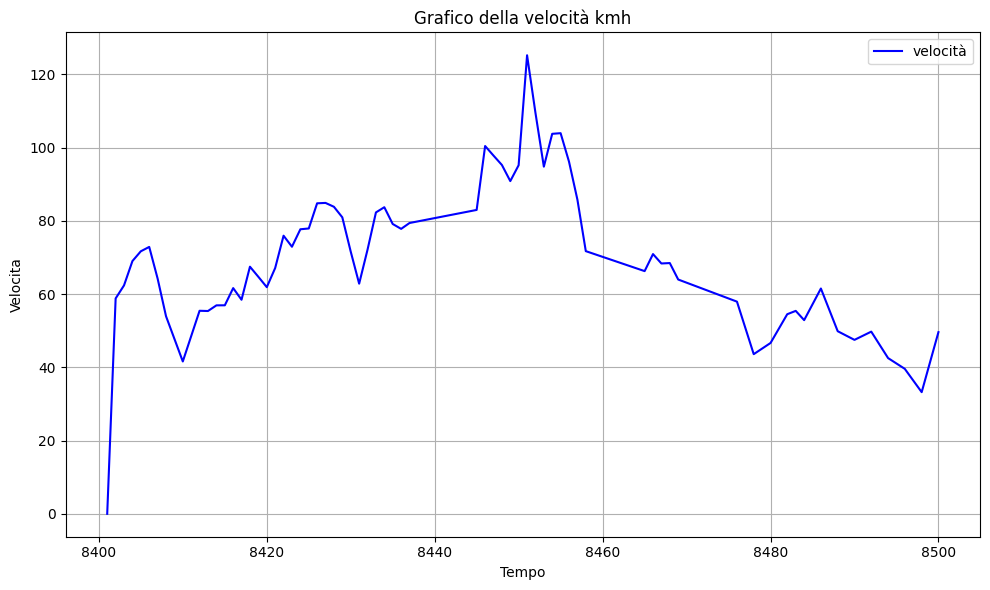

In [16]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['velocita'] * 3.6, 
    label='velocità', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Velocita')
plt.title('Grafico della velocità kmh')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

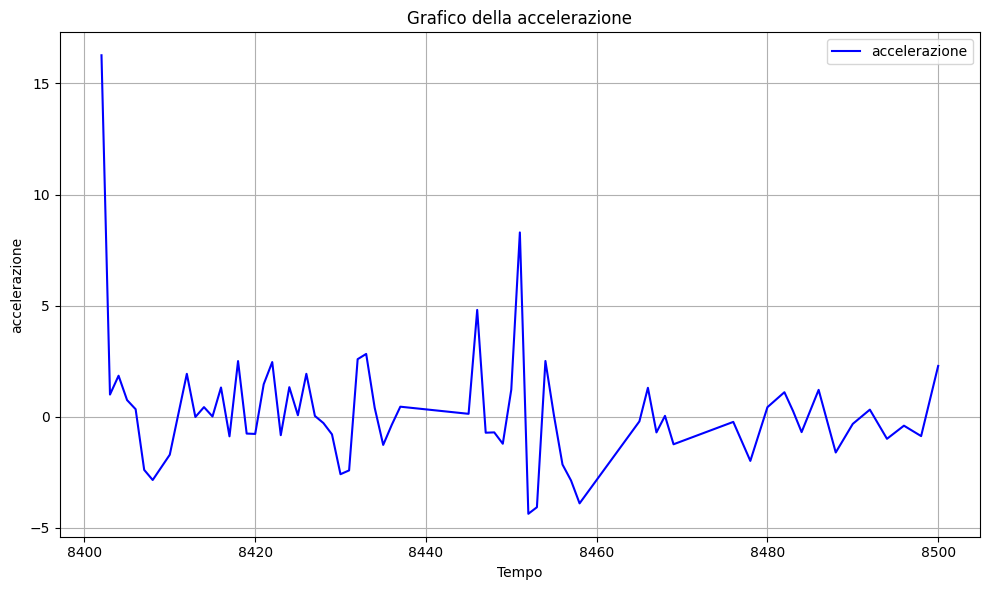

In [17]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['accelerazione'], 
    label='accelerazione', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('accelerazione')
plt.title('Grafico della accelerazione')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

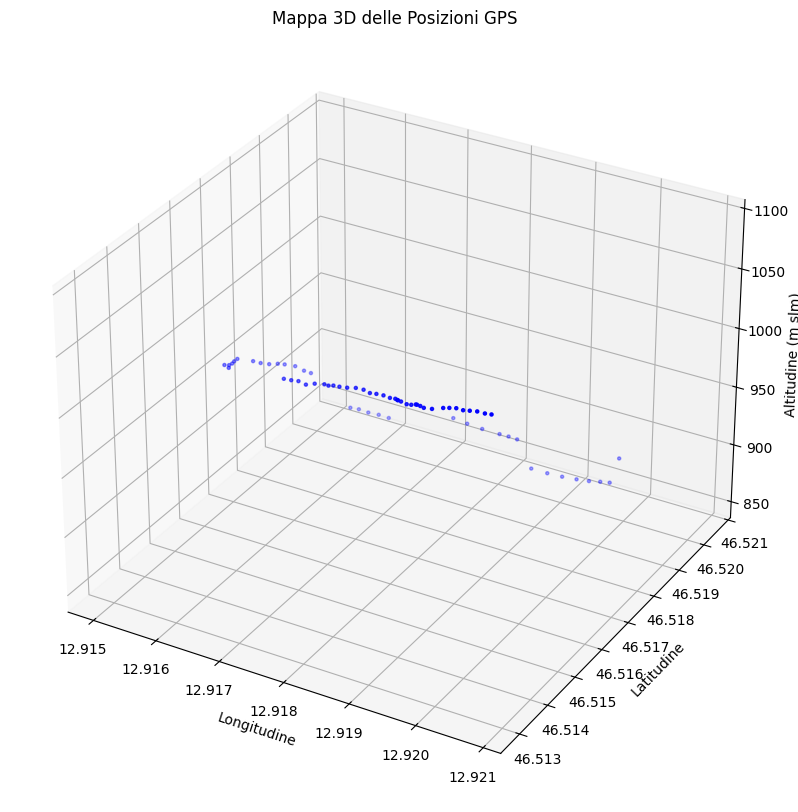

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Crea il grafico 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Estrai i dati
latitudini = gdf1['latitudine']
longitudini = gdf1['longitudine']
altitudine = gdf1['altitudine']

# Plot dei punti GPS
ax.scatter(longitudini, latitudini, altitudine, color='blue', marker='o', s=5)

# Imposta etichette e titolo
ax.set_title("Mappa 3D delle Posizioni GPS")
ax.set_xlabel("Longitudine")
ax.set_ylabel("Latitudine")
ax.set_zlabel("Altitudine (m slm)")

plt.show()


In [19]:
import plotly.graph_objects as go


# Mostra il grafico
import plotly.io as pio
pio.renderers.default = "browser"# browser notebook
fig.show()

# Crea la figura con la traccia 3D
fig = go.Figure()

# Aggiungi la linea continua
fig.add_trace(go.Scatter3d(
    x=gdf1['longitudine'],
    y=gdf1['latitudine'],
    z=gdf1['altitudine'],
    mode='lines',  # Usa linee anziché punti
    line=dict(
        color=gdf1['velocita'],  # Colore in base alla velocità
        colorscale='Reds',  # Scala colori da blu a rosso
        width=10  # Larghezza della linea
    ),
))

# Configura la visualizzazione
fig.update_layout(
    title="Mappa 3D Interattiva delle Posizioni GPS colorata per Velocità",
    scene=dict(
        xaxis_title="Longitudine",
        yaxis_title="Latitudine",
        zaxis_title="Altitudine"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Mostra il grafico
fig.show()




/tmp/ipykernel_52544/1209753994.py:7: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

